# Cross-Canada Survey of Radon Concentrations in Homes

In [55]:
import numpy as np
import requests
import pandas as pd
import plotly.express as px

print('Libraries imported')


Libraries imported


We downloaded the data online, however we had to download it as a csv file. In the file, there were additional columns that needed to be removed as the were empty. For the analysis we wish to coverm we are only interested in the Province/Territory variable.

In [56]:
url = "https://health.canada.ca/apps/open-data/radon-concentrations/radon-concentration.csv"

dfs = pd.read_csv(url)

dfs = dfs.drop(['ResultNumber','HealthRegionCode2007','Health Region2007','TestDurationInDays','ForwardSortationAreaCodes','Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 12'],axis = 1)

dfs.head()

,ProvinceTerritory,AverageRadonConcentrationInBqPerM3
0,NL,20
1,NL,36
2,NL,<15
3,NL,31
4,NL,26


To do the statistical tests on the dataset, we needed the Average Radon Concentration to be integer values. To achieve this we had to remove the values that were "<15", now this will cause some issues with the analysis but without speaking to the owner of the dataset, there is nothing we can do about this.

In [57]:
for badLabel in ['<15']:
    dfs = dfs[dfs["AverageRadonConcentrationInBqPerM3"] != badLabel]

dfs = dfs[dfs["AverageRadonConcentrationInBqPerM3"].notnull()]
dfs["AverageRadonConcentrationInBqPerM3"].unique()

dfs['AverageRadonConcentrationInBqPerM3'] = dfs['AverageRadonConcentrationInBqPerM3'].astype(int)

dfs = dfs[dfs["ProvinceTerritory"] != 'NU']

dfs.describe()

,AverageRadonConcentrationInBqPerM3
count,11218.000000
mean,116.998395
std,183.117320
min,15.000000
25%,30.000000
50%,72.000000
75%,133.000000
max,5657.000000


We wanted to see if there were any significant differences between the provinces. The first step would be to group by the province/territory and find some summary statistics.

In [58]:
dfsbyPT = dfs.groupby('ProvinceTerritory')
dfsbyPT.describe()

AverageRadonConcentrationInBqPerM3                          \
                                               count        mean         std   
ProvinceTerritory                                                              
AB                                            1077.0   96.046425   95.152537   
BC                                            1162.0  102.542169  167.349146   
MB                                            1102.0  160.348457  177.987718   
NB                                             728.0  203.230769  336.061973   
NL                                             479.0   86.991649  142.047475   
NS                                             428.0  125.728972  265.850976   
NT                                             146.0   85.910959  101.656346   
ON                                            3292.0   97.383961  160.787093   
PE                                              71.0   68.070423   76.382183   
QC                                            1348.0  104.034866  161.933688   
SK                                            1169.0  130.225834  137.278958   
YT                                             216.0  182.027778  313.686081   

                                                       
                    min    25%    50%     75%     max  
ProvinceTerritory                                      
AB                 15.0  37.00   75.0  121.00  1391.0  
BC                 15.0  25.00   55.0  110.00  2941.0  
MB                 15.0  55.00  110.5  203.00  1903.0  
NB                 15.0  37.00  104.0  227.00  5590.0  
NL                 15.0  22.00   35.0   97.00  1548.0  
NS                 15.0  25.00   42.5  114.25  2692.0  
NT                 15.0  29.00   58.0  109.75   924.0  
ON                 15.0  28.00   63.0  114.00  5657.0  
PE                 15.0  22.50   31.0   87.00   415.0  
QC                 15.0  26.00   55.0  121.00  2923.0  
SK                 15.0  60.00  100.0  159.00  2165.0  
YT                 15.0  43.75   92.5  165.75  2357.0

The next step will be to graph the values and see if they follow a normal distribution. Using a histogram, we can see that any assumption of normality is broken.

Text(0.5, 0.09, 'Concentration (Bq/m^3)')

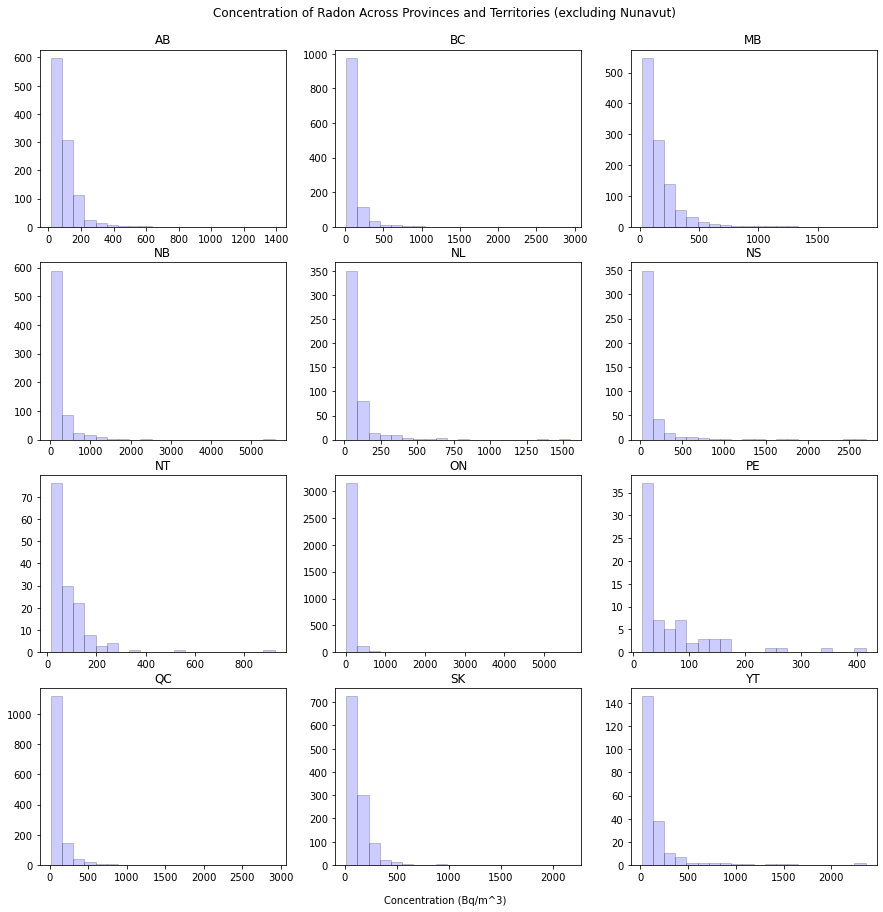

In [59]:
dfs_noNU = dfs[dfs["ProvinceTerritory"] != 'NU']
dfsbyPT_noNU = dfs_noNU.groupby("ProvinceTerritory")
fig, axs = plt.subplots(4,3)
fig.set_size_inches(15,15)
a = 0
for P in list(dfsbyPT_noNU.groups.keys()):
#    print(a%2)
    axs[int((a-a%3)/3),a%3].hist(dfsbyPT_noNU.get_group(P)['AverageRadonConcentrationInBqPerM3'],20,density=False,
    alpha=0.2,
    color='blue',
    edgecolor='k')
    axs[int((a-a%3)/3),a%3].set_title(P)
    a = a+1
fig.suptitle('Concentration of Radon Across Provinces and Territories (excluding Nunavut)',x=0.5,y=0.92)
fig.text(0.5, 0.09, 'Concentration (Bq/m^3)', ha='center')

We can log transform the data but since there is a lower limit to the data, there is not much we can do about the normality of the data. We also see that when we consider the territory Nunavet, there are only 11 observations which will drastically change our analysis, so we will drop them from the dataset.

[Text(0, 0, 'AB'),
 Text(0, 0, 'BC'),
 Text(0, 0, 'MB'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'NL'),
 Text(0, 0, 'NS'),
 Text(0, 0, 'NT'),
 Text(0, 0, 'ON'),
 Text(0, 0, 'PE'),
 Text(0, 0, 'QC'),
 Text(0, 0, 'SK'),
 Text(0, 0, 'YT')]

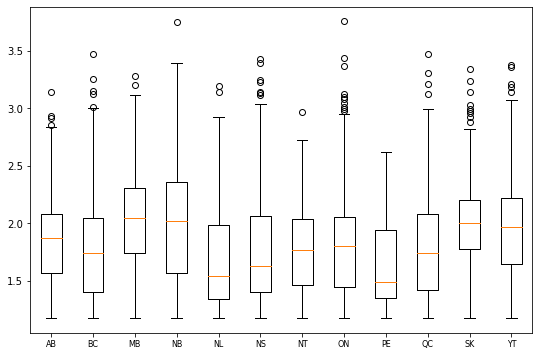

In [60]:
data_to_plot = []

for P in dfsbyPT.groups.keys():
    temp = np.log10(dfsbyPT.get_group(P)['AverageRadonConcentrationInBqPerM3'])
    data_to_plot.append(temp)

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(data_to_plot)
ax.set_xticklabels( dfsbyPT.groups.keys(), fontsize = 8)
#plt.xticks(np.arange(1,14), dfsbyPT.groups.keys())

Since we can not assume normality, we have to use a non-parametric anova test. To do so we will use the Kruskal Wallis test.

In [62]:
from scipy import stats

AB = data_to_plot[0]
BC = data_to_plot[1]
MB = data_to_plot[2]
NB = data_to_plot[3]
NL = data_to_plot[4]
NS = data_to_plot[5]
NT = data_to_plot[6]
ON = data_to_plot[7]
PE = data_to_plot[8]
QC = data_to_plot[9]
SK = data_to_plot[10]
YT = data_to_plot[11]

stats.kruskal(AB,BC,MB,NB,NL,NS,NT,ON,PE,QC,SK,YT)

KruskalResult(statistic=713.8841997074114, pvalue=5.693026989867524e-146)

Since there is a significant difference between the provinces, we can use a post hoc test to find the pairwise comparisons. To correct for FWER we will use a sidak correction.

In [63]:
import scikit_posthocs as sp

#data = pd.DataFrame({"AB": AB, "BC": BC, "MB": MB, "NB":NB,
                    #"NL":NL, "NS" : NS, "NT" : NT, "ON":ON,
                    #"PE" : PE, "QC" : QC, "SK" : SK, "YT" :YT })
#data = data.melt(var_name='groups', value_name='values')
#data
#data = [AB,BC,MB,NB,NL,NS,NT,ON,PE,QC,SK,YT]
sp.posthoc_dunn(dfs, p_adjust = 'sidak', group_col = "ProvinceTerritory", val_col = "AverageRadonConcentrationInBqPerM3")

,AB,BC,MB,NB,NL,NS,NT,ON,PE,QC,SK,YT
AB,1.000000e+00,3.722462e-08,0.000000e+00,9.303912e-08,3.663736e-14,1.138069e-04,5.956655e-01,5.283673e-06,1.388570e-03,1.458035e-05,1.230283e-11,6.420348e-02
BC,3.722462e-08,1.000000e+00,0.000000e+00,0.000000e+00,4.981123e-02,1.000000e+00,1.000000e+00,8.700289e-01,8.993220e-01,9.999998e-01,0.000000e+00,4.915268e-10
MB,0.000000e+00,0.000000e+00,1.000000e+00,9.998059e-01,0.000000e+00,0.000000e+00,2.562996e-09,0.000000e+00,3.118572e-11,0.000000e+00,9.999996e-01,9.995101e-01
NB,9.303912e-08,0.000000e+00,9.998059e-01,1.000000e+00,0.000000e+00,0.000000e+00,1.392546e-06,0.000000e+00,4.394014e-09,0.000000e+00,1.000000e+00,1.000000e+00
NL,3.663736e-14,4.981123e-02,0.000000e+00,0.000000e+00,1.000000e+00,4.825388e-01,6.604065e-01,1.042252e-05,1.000000e+00,7.778942e-04,0.000000e+00,0.000000e+00
NS,1.138069e-04,1.000000e+00,0.000000e+00,0.000000e+00,4.825388e-01,1.000000e+00,1.000000e+00,9.989275e-01,9.727061e-01,1.000000e+00,0.000000e+00,3.437078e-08
NT,5.956655e-01,1.000000e+00,2.562996e-09,1.392546e-06,6.604065e-01,1.000000e+00,1.000000e+00,1.000000e+00,9.103169e-01,1.000000e+00,1.156161e-07,1.031956e-03
ON,5.283673e-06,8.700289e-01,0.000000e+00,0.000000e+00,1.042252e-05,9.989275e-01,1.000000e+00,1.000000e+00,3.067263e-01,1.000000e+00,0.000000e+00,4.407541e-08
PE,1.388570e-03,8.993220e-01,3.118572e-11,4.394014e-09,1.000000e+00,9.727061e-01,9.103169e-01,3.067263e-01,1.000000e+00,5.196503e-01,6.601613e-10,1.397013e-06
QC,1.458035e-05,9.999998e-01,0.000000e+00,0.000000e+00,7.778942e-04,1.000000e+00,1.000000e+00,1.000000e+00,5.196503e-01,1.000000e+00,0.000000e+00,2.984396e-08
